# MobileNetV2 for Sign language Recognition

steps of notebook:

1. Here we will attempt to preprocess the data however we need to stick to mobilenetV2's preprocessing so by utilizing the package this package will scale pixel values so they are between -1 and 1 by scaling images sample-wise (it will utilise each images mean and std not the entire datasets).

2. After preprocessing the images will be put through ImageDataGenerator to add variation to our images by scaling, shifting, rotating, flipping and zooming

In [1]:
#mount google drive
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/MyDrive/kaggle/smallsign'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#extract and overwrite images to place files in colab storage for faster preprocessing
!unzip /content/gdrive/MyDrive/kaggle/smallsign/asl-alphabet.zip -d /content/gdrive/MyDrive/kaggle/smallsign

Archive:  /content/gdrive/MyDrive/kaggle/smallsign/asl-alphabet.zip
replace /content/gdrive/MyDrive/kaggle/smallsign/asl_alphabet_test/asl_alphabet_test/A_test.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
import pandas as pd #dataframe and csv reading
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import numpy as np
from time import time
import glob
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten
from tensorflow.keras.layers import Dense, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, Activation
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import Sequential, Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard, CSVLogger#, LearningRateScheduler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split

import imutils
import gc

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
def file_from_df(df, size):

    now = time()
    i=1
    target_list = []
    for files in df['img_path'].tolist():

        if i%100 == 0:
            print(i)
            print(img.shape)

        img = cv2.imread(files, cv2.IMREAD_UNCHANGED)
        res = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)
        array = img_to_array(res)
        processed = preprocess_input(array)

        target_list.append(processed)

        i += 1

    loaded_imgs = np.array(target_list, dtype='float32')

    return loaded_imgs

In [5]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'nothing', 'space', 'del']

In [6]:
# train_data_path = '/content/gdrive/MyDrive/lewis_letters' # our generated images
train_data_path = '/content/gdrive/MyDrive/kaggle/smallsign/asl_alphabet_train/asl_alphabet_train/'
test_data_path = '/content/gdrive/MyDrive/kaggle/smallsign/asl_alphabet_test/asl_alphabet_test/'
# train_data_path2 = '/content/gdrive/MyDrive/kaggle/sign/ASL_Dataset/Train/' #larger dataset
# test_data_path2 = '/content/gdrive/MyDrive/kaggle/sign/ASL_Dataset/Test/' #larger dataset

train_folders = os.listdir(train_data_path)
test_folders = os.listdir(test_data_path)

train_labels = []
train_img_path = []

for letter in train_folders:
    path = os.path.join(train_data_path, letter + '/')
    for file in glob.glob(path + '*'):
        train_labels.append(letter)
        train_img_path.append(file)

#test doesnt contain folders
for letter in test_folders:
    train_labels.append(letter.split('_')[0])
    train_img_path.append(test_data_path + letter)

df_data = pd.DataFrame(zip(train_labels, train_img_path), columns = ['label', 'img_path'])
df_data.to_csv('train.csv', index = False)

In [7]:
#ensure data is read in correctly
print(f'Number of unique images: {len(set(df_data.img_path.tolist()))}')
print(f'Length of dataframe: {len(df_data)}') 

Number of unique images: 87028
Length of dataframe: 87028


In [8]:
#check class distribution
df_data.label.value_counts()

V          3001
K          3001
G          3001
Q          3001
W          3001
I          3001
Z          3001
F          3001
space      3001
L          3001
U          3001
T          3001
J          3001
C          3001
Y          3001
O          3001
S          3001
D          3001
E          3001
nothing    3001
H          3001
B          3001
P          3001
R          3001
M          3001
A          3001
N          3001
X          3001
del        3000
Name: label, dtype: int64

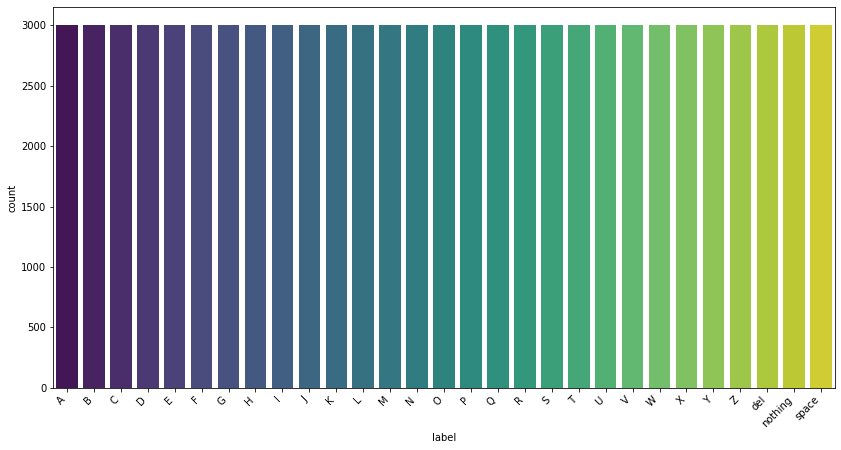

In [9]:
plt.figure(figsize = (14, 7))

class_dist = sns.countplot(
    data= df_data,
    x='label',
    palette='viridis'
)

class_dist.set_xticklabels(class_dist.get_xticklabels(), rotation=45, horizontalalignment='right')

None

In [10]:
#ensure files are read correctly
for files in df_data['img_path'][:5].tolist():
    print(files)

/content/gdrive/MyDrive/kaggle/smallsign/asl_alphabet_train/asl_alphabet_train/A/A411.jpg
/content/gdrive/MyDrive/kaggle/smallsign/asl_alphabet_train/asl_alphabet_train/A/A412.jpg
/content/gdrive/MyDrive/kaggle/smallsign/asl_alphabet_train/asl_alphabet_train/A/A413.jpg
/content/gdrive/MyDrive/kaggle/smallsign/asl_alphabet_train/asl_alphabet_train/A/A414.jpg
/content/gdrive/MyDrive/kaggle/smallsign/asl_alphabet_train/asl_alphabet_train/A/A415.jpg


In [11]:
data = pd.read_csv('train.csv')

images = []

size_dim = (96,96) # Maximum size for ram avalible

images = file_from_df(data, size_dim)

labels = data['label'].tolist()

LE = LabelEncoder()
labels = LE.fit_transform(labels)

#set up data generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.1
)

100
(200, 200, 3)
200
(200, 200, 3)
300
(200, 200, 3)
400
(200, 200, 3)
500
(200, 200, 3)
600
(200, 200, 3)
700
(200, 200, 3)
800
(200, 200, 3)
900
(200, 200, 3)
1000
(200, 200, 3)
1100
(200, 200, 3)
1200
(200, 200, 3)
1300
(200, 200, 3)
1400
(200, 200, 3)
1500
(200, 200, 3)
1600
(200, 200, 3)
1700
(200, 200, 3)
1800
(200, 200, 3)
1900
(200, 200, 3)
2000
(200, 200, 3)
2100
(200, 200, 3)
2200
(200, 200, 3)
2300
(200, 200, 3)
2400
(200, 200, 3)
2500
(200, 200, 3)
2600
(200, 200, 3)
2700
(200, 200, 3)
2800
(200, 200, 3)
2900
(200, 200, 3)
3000
(200, 200, 3)
3100
(200, 200, 3)
3200
(200, 200, 3)
3300
(200, 200, 3)
3400
(200, 200, 3)
3500
(200, 200, 3)
3600
(200, 200, 3)
3700
(200, 200, 3)
3800
(200, 200, 3)
3900
(200, 200, 3)
4000
(200, 200, 3)
4100
(200, 200, 3)
4200
(200, 200, 3)
4300
(200, 200, 3)
4400
(200, 200, 3)
4500
(200, 200, 3)
4600
(200, 200, 3)
4700
(200, 200, 3)
4800
(200, 200, 3)
4900
(200, 200, 3)
5000
(200, 200, 3)
5100
(200, 200, 3)
5200
(200, 200, 3)
5300
(200, 200, 3)
54

In [12]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

y_train = to_categorical(y_train)
y_test_check = y_test.copy()
y_test = to_categorical(y_test)

In [13]:
base_model = MobileNetV2(weights="imagenet",
                        include_top=False,
                        input_shape=(96, 96, 3))

# the base model
head_model = base_model.output

head_model = Flatten(name="flatten")(head_model)

head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.35)(head_model)

head_model = Dense(29, activation="softmax")(head_model)

model = Model(inputs=base_model.input, outputs=head_model)

for layer in base_model.layers: 
    layer.trainable = False

# for layer in base_model.layers[0:-12]:
#     layer.trainable = False

model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["accuracy"])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [14]:
model_path = '/content/gdrive/MyDrive/Models'
log_path = '/content/gdrive/MyDrive/Model_log' 
model_name_mn = 'mnunfreeze.weights.best.{epoch:03d}-{val_accuracy:.4f}.hdf5'
tb_path = '/content/gdrive/MyDrive/TB_logs'

In [15]:
callbacks = [
    ModelCheckpoint(
        filepath = os.path.join(model_path, model_name_mn),
        monitor = 'val_loss', 
        save_best_only = True, 
        mode = 'max'
        ),

    CSVLogger(
        filename=os.path.join(log_path, 'log_mn.csv'), 
        separator = ',', 
        append = True
        ),

    EarlyStopping(
        monitor = 'val_loss',
        patience = 5
        ),

    TensorBoard(
        log_dir = tb_path,
        histogram_freq = 10,
        write_graph = True,
        write_images = True,
        write_steps_per_second = False,
        update_freq = 'epoch',
        profile_batch = 0,
        embeddings_freq = 0,
        embeddings_metadata = None
        )
    ]

In [27]:
K.set_value(model.optimizer.lr, 1e-5)

In [28]:
model.fit(
        datagen.flow(X_train, y_train),
        validation_data = (X_test, y_test),
        epochs = 200,
        batch_size = 32,
        callbacks = callbacks
        )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/200
2176/2176 [==============================] - 181s 83ms/step - loss: 0.1596 - accuracy: 0.9468 - val_loss: 0.0648 - val_accuracy: 0.9768
Epoch 2/200
2176/2176 [==============================] - 179s 82ms/step - loss: 0.1464 - accuracy: 0.9508 - val_loss: 0.0628 - val_accuracy: 0.9785
Epoch 3/200
2176/2176 [==============================] - 177s 82ms/step - loss: 0.1438 - accuracy: 0.9520 - val_loss: 0.0590 - val_accuracy: 0.9794
Epoch 4/200
2176/2176 [==============================] - 177s 82ms/step - loss: 0.1400 - accuracy: 0.9536 - val_loss: 0.0590 - val_accuracy: 0.9799
Epoch 5/200
2176/2176 [==============================] - 176s 81ms/step - loss: 0.1400 - accuracy: 0.9535 - val_loss: 0.0594 - val_accuracy: 0.9795
Epoch 6/200
  22/2176 [..............................] - ETA: 2:47 - loss: 0.1541 - accuracy: 0.9460

KeyboardInterrupt: ignored

this result is different to the one in our presentation as that one didnt use image augmentations.

In [29]:
predictions = np.argmax(model.predict(X_test), axis=-1)

In [30]:
predictions = predictions.tolist()

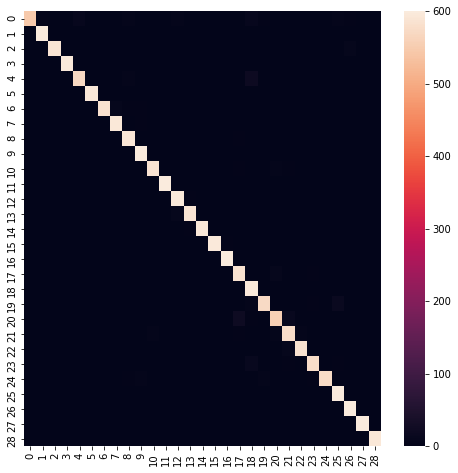

In [31]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test_check, predictions))
plt.show()

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test_check,predictions))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       600
           1       0.99      1.00      0.99       600
           2       1.00      0.98      0.99       600
           3       1.00      0.99      0.99       600
           4       0.98      0.95      0.96       600
           5       1.00      0.99      1.00       600
           6       1.00      0.97      0.98       601
           7       0.99      0.99      0.99       601
           8       0.97      0.99      0.98       600
           9       0.97      1.00      0.98       600
          10       0.98      0.98      0.98       601
          11       1.00      1.00      1.00       600
          12       0.97      0.99      0.98       600
          13       0.98      0.98      0.98       600
          14       0.99      0.99      0.99       601
          15       0.99      0.99      0.99       600
          16       0.99      1.00      0.99       600
          17       0.94    

classes 17 18 and 25 are difficult to predict. These correspond to R, S, and Z. 

In the real world Z requires movement which is likely the cause of the misclassification. However, R and S have little overlap.

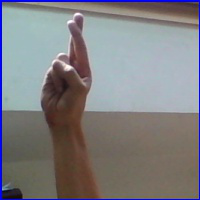

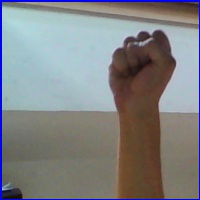

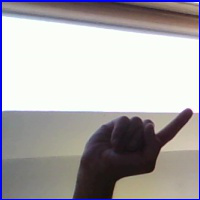

In [44]:
from PIL import Image

R = df_data[df_data.label == 'R']
S = df_data[df_data.label == 'S']
Z = df_data[df_data.label == 'Z']

R_img = Image.open(R.img_path.iloc[0])
S_img = Image.open(S.img_path.iloc[0])
Z_img = Image.open(Z.img_path.iloc[0])

display(R_img)
display(S_img)
display(Z_img)

In [46]:
model_custom_json = model.to_json()
with open("model_mn.json", "w") as json_file_custom:
    json_file_custom.write(model_custom_json)
model.save_weights("model_mn.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [47]:
from google.colab import files

files.download("model_mn.json")
files.download("model_mn.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
le_name_mapping = dict(zip(LE.classes_, LE.transform(LE.classes_)))
le_name_mapping

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 'del': 26,
 'nothing': 27,
 'space': 28}

In [48]:
df = pd.DataFrame(le_name_mapping.items(), columns=['label', 'argmax_val'])

In [49]:
df.to_csv('results_dict.csv',index=False)